In [1]:
# Hough Transform
# from https://alyssaq.github.io/2014/understanding-hough-transform/

# Cartesian Space
## y = mx + b

## where:    
## m = slope of the line (rise/run)   
## b = y-intercept

# Polar Space
# ρ = x cos θ + y sin θ

# where:
# ρ  (rho) = distance from origin to the line. [-max_dist to max_dist].
#   max_dist is the diagonal length of the image.  
# θ = angle from origin to the line. [-90° to 90°]

import numpy as np
import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import show_img

In [2]:
def hough_line(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width**2 + height**2)).astype(int)   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0)
    
    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    
    # Hough accumulator array of theta vs rho
    #print(type(diag_len), type(num_thetas))
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges
    
    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
    
        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]).astype(int) + diag_len
            accumulator[rho, t_idx] += 1
    
    return accumulator, thetas, rhos

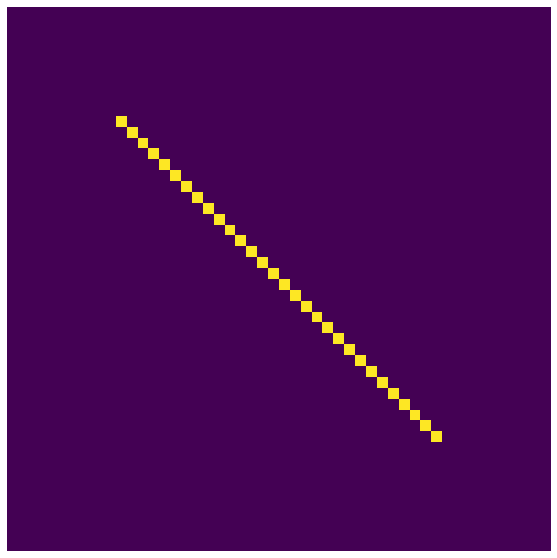

In [3]:
# Create binary image and call hough_line
image = np.zeros((50,50))
image[10:40, 10:40] = np.eye(30)
show_img(image)

In [4]:
accumulator, thetas, rhos = hough_line(image)

# Easiest peak finding based on max votes
idx = np.argmax(accumulator)
rho = rhos[idx // accumulator.shape[1]]
theta = thetas[idx % accumulator.shape[1]]
print("rho = {0:.2f}, theta = {1:.0f} degrees".format(rho, np.rad2deg(theta)))

rho = 0.50, theta = -45 degrees


In [7]:
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from skimage.feature import canny
import matplotlib.pyplot as plt
from matplotlib import cm

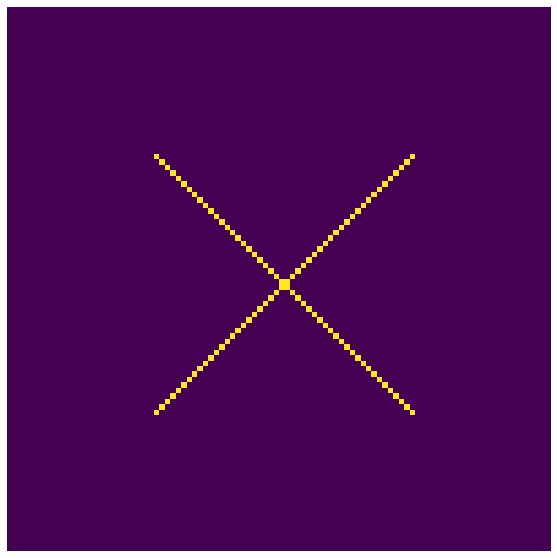

In [8]:
# Constructing a test iamge
img = np.zeros((100, 100))
idx = np.arange(27, 75)
img[idx[::-1], idx] = 1
img[idx, idx] = 1

show_img(img)

In [9]:
# Classic straigt-line hough transform
h, theta, d = hough_line(img)

Text(0.5, 1.0, 'Detected lines')

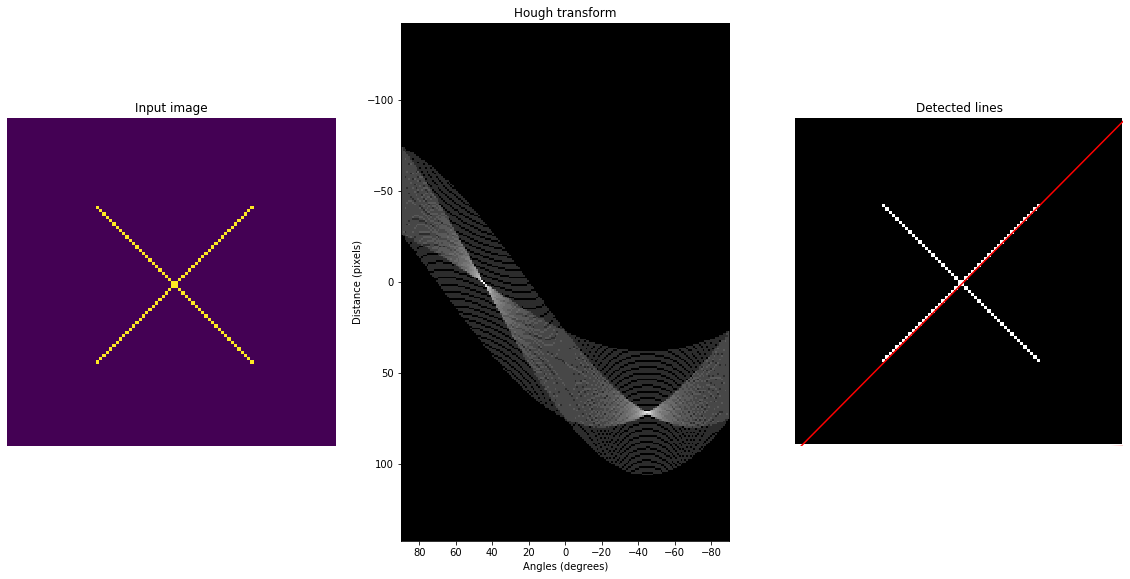

In [30]:
# Generatring fugure 1
fig, axes = plt.subplots(1,3, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title("Input image")
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]),
                    np.rad2deg(theta[0]),
                    d[-1], d[0]],
                    cmap=cm.gray)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')


ax[2].imshow(img, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, img.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, img.shape[1]))
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title("Detected lines")

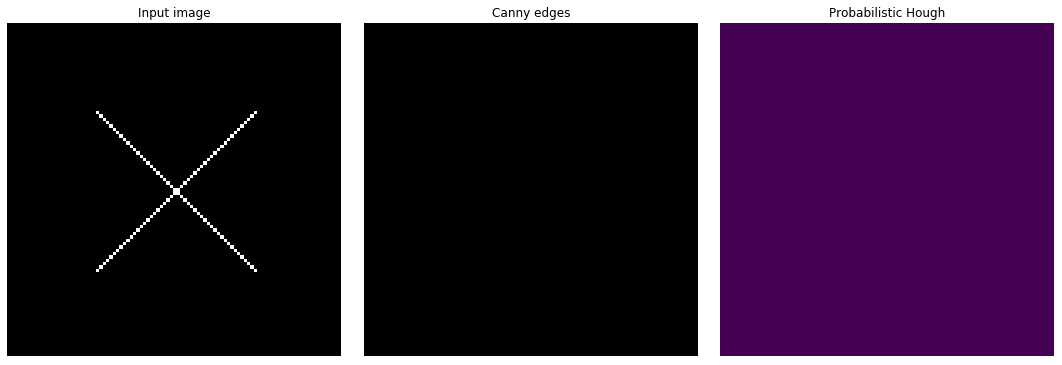

In [33]:
# Line finding using the Probabilistic Hough Transform
image = img
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()